## Imports and Setup



In [1]:
import os
import json
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import logging
import yaml
import random
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Base directory
base_dir = Path('datasets2')

logger.info("Setup complete. Base directory set to: %s", base_dir)

2025-03-21 15:21:42,959 - INFO - Setup complete. Base directory set to: datasets2


## Class Standardization and Mapping



In [2]:
# Selected classes to process
selected_classes = [
    'pedestrian', 'car', 'bus', 'truck', 'motorcycle', 'bicycle', 'dog',
    'door', 'openeddoor', 'chair', 'table', 'pole'
]

# Class mapping for standardization
class_mapping = {
    'people': 'pedestrian',
    'person': 'pedestrian',
    'motorbike': 'motorcycle',
    'bike': 'bicycle',
    'open_door': 'openeddoor'
}

# Function to standardize class names
def standardize_class(cls):
    cls = cls.lower()
    return class_mapping.get(cls, cls)

logger.info("Selected classes: %s", selected_classes)
logger.info("Class mapping defined for standardization.")

2025-03-21 15:21:52,394 - INFO - Selected classes: ['pedestrian', 'car', 'bus', 'truck', 'motorcycle', 'bicycle', 'dog', 'door', 'openeddoor', 'chair', 'table', 'pole']
2025-03-21 15:21:52,395 - INFO - Class mapping defined for standardization.


## Parsing Functions for Each Dataset



In [ ]:
# Parse Ninja Annotations (JSON)
def parse_ninja_annotations(folder):
    class_counts = defaultdict(int)
    image_bbox_map = {}
    splits = ['train', 'valid', 'test']
    for split in splits:
        ann_folder = folder / split / 'ann'
        img_folder = folder / split / 'img'
        if not ann_folder.exists() or not img_folder.exists():
            logger.warning("Missing 'ann' or 'img' folder in Ninja %s split", split)
            continue
        ann_files = list(ann_folder.glob('*.json'))
        logger.info("Found %d annotation files in Ninja %s split", len(ann_files), split)
        for ann_file in tqdm(ann_files, desc=f"Parsing Ninja {split}"):
            base_name = ann_file.stem.split('.')[0]
            img_file = next((img_folder / (base_name + ext) for ext in ['.jpg', '.jpeg', '.png'] if (img_folder / (base_name + ext)).exists()), None)
            if not img_file:
                logger.warning("No matching image found for annotation %s", ann_file)
                continue
            img_key = f"{split}/{img_file.name}"
            try:
                with open(ann_file, 'r') as f:
                    data = json.load(f)
                bboxes = []
                for obj in data.get('objects', []):
                    cls = standardize_class(obj.get('classTitle', 'unknown'))
                    if cls in selected_classes:
                        points = obj.get('points', {}).get('exterior', [])
                        if len(points) >= 2:
                            x_min, y_min = points[0]
                            x_max, y_max = points[1]
                            bboxes.append((cls, x_min, y_min, x_max, y_max))
                            class_counts[cls] += 1
                if bboxes:
                    image_bbox_map[img_key] = bboxes
            except Exception as e:
                logger.error("Error parsing Ninja annotation %s: %s", ann_file, e)
    return class_counts, image_bbox_map

# Parse WOTR Annotations (XML)
def parse_wotr_annotations(folder):
    class_counts = defaultdict(int)
    image_bbox_map = {}
    ann_folder = folder / 'Annotations'
    img_folder = folder / 'JPEGImages'
    if not ann_folder.exists() or not img_folder.exists():
        logger.error("Missing 'Annotations' or 'JPEGImages' folder in WOTR")
        return class_counts, image_bbox_map
    ann_files = list(ann_folder.glob('*.xml'))
    logger.info("Found %d XML annotation files in WOTR", len(ann_files))
    for ann_file in tqdm(ann_files, desc="Parsing WOTR"):
        base_name = ann_file.stem  # Use XML filename as base, not internal tag
        img_path = img_folder / f"{base_name}.jpg" 
        if not img_path.exists():
            logger.warning("No matching image found for WOTR annotation %s at %s", ann_file, img_path)
            continue
        img_key = img_path.name
        try:
            tree = ET.parse(ann_file)
            root = tree.getroot()
            bboxes = []
            for obj in root.findall('object'):
                cls = standardize_class(obj.find('name').text)
                if cls in selected_classes:
                    bbox = obj.find('bndbox')
                    x_min = float(bbox.find('xmin').text)
                    y_min = float(bbox.find('ymin').text)
                    x_max = float(bbox.find('xmax').text)
                    y_max = float(bbox.find('ymax').text)
                    bboxes.append((cls, x_min, y_min, x_max, y_max))
                    class_counts[cls] += 1
            if bboxes:
                image_bbox_map[img_key] = bboxes
        except Exception as e:
            logger.error("Error parsing WOTR annotation %s: %s", ann_file, e)
    return class_counts, image_bbox_map

# Parse Risk-Detection-1 Annotations (YOLO)
def parse_risk_detection_annotations(folder):
    yaml_path = folder / 'data.yaml'
    with open(yaml_path, 'r') as f:
        class_names = yaml.safe_load(f).get('names', [])
    class_counts = defaultdict(int)
    image_bbox_map = {}
    splits = ['train', 'valid', 'test']
    for split in splits:
        label_folder = folder / split / 'labels'
        img_folder = folder / split / 'images'
        if not label_folder.exists() or not img_folder.exists():
            logger.warning("Missing 'labels' or 'images' folder in Risk %s split", split)
            continue
        label_files = list(label_folder.glob('*.txt'))
        logger.info("Found %d label files in Risk %s split", len(label_files), split)
        for label_file in tqdm(label_files, desc=f"Parsing Risk {split}"):
            base_name = label_file.stem
            img_file = next((img_folder / (base_name + ext) for ext in ['.jpg', '.jpeg', '.png'] if (img_folder / (base_name + ext)).exists()), None)
            if not img_file:
                logger.warning("No matching image found for Risk label %s", label_file)
                continue
            img_key = f"{split}/{img_file.name}"
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                bboxes = []
                img = cv2.imread(str(img_file))
                if img is None:
                    logger.warning("Failed to load image %s", img_file)
                    continue
                h, w, _ = img.shape
                for line in lines:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    idx = int(parts[0])
                    cls = standardize_class(class_names[idx]) if idx < len(class_names) else f"unknown_{idx}"
                    if cls in selected_classes:
                        x_center, y_center, width, height = map(float, parts[1:])
                        x_min = (x_center - width / 2) * w
                        y_min = (y_center - height / 2) * h
                        x_max = (x_center + width / 2) * w
                        y_max = (y_center + height / 2) * h
                        bboxes.append((cls, x_min, y_min, x_max, y_max))
                        class_counts[cls] += 1
                if bboxes:
                    image_bbox_map[img_key] = bboxes
            except Exception as e:
                logger.error("Error parsing Risk label %s: %s", label_file, e)
    return class_counts, image_bbox_map

logger.info("Parsing functions defined for Ninja, WOTR, and Risk-Detection-1 datasets.")

2025-03-21 15:22:12,159 - INFO - Parsing functions defined for Ninja, WOTR, and Risk-Detection-1 datasets.


## Annotation Counting



In [ ]:
# Define dataset folders
ninja_folder = base_dir / 'ninja'
wotr_folder = base_dir / 'WOTR'/'WOTR'
risk_folder = base_dir / 'risk-detection-1'

# Parse annotations
logger.info("Starting annotation parsing for Ninja dataset...")
ninja_class_counts, ninja_image_bbox_map = parse_ninja_annotations(ninja_folder)

logger.info("Starting annotation parsing for WOTR dataset...")
wotr_class_counts, wotr_image_bbox_map = parse_wotr_annotations(wotr_folder)

logger.info("Starting annotation parsing for Risk-Detection-1 dataset...")
risk_class_counts, risk_image_bbox_map = parse_risk_detection_annotations(risk_folder)


2025-03-21 15:23:39,573 - INFO - Starting annotation parsing for Ninja dataset...
2025-03-21 15:23:39,577 - INFO - Found 1012 annotation files in Ninja train split
Parsing Ninja train:   0%|          | 0/1012 [00:00<?, ?it/s]2025-03-21 15:23:39,589 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_79.JPG.json
2025-03-21 15:23:39,598 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_73.JPG.json
2025-03-21 15:23:39,601 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_22.JPG.json
2025-03-21 15:23:39,603 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_18.JPG.json
2025-03-21 15:23:39,605 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_74.JPG.json
2025-03-21 15:23:39,607 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_19.JPG.json
2025-03-21 15:23:39,609 - WARNING - No matching image f

## Combining Data from All Datasets



In [9]:
# After parsing datasets
ninja_class_counts, ninja_image_bbox_map = parse_ninja_annotations(ninja_folder)
wotr_class_counts, wotr_image_bbox_map = parse_wotr_annotations(wotr_folder)
risk_class_counts, risk_image_bbox_map = parse_risk_detection_annotations(risk_folder)

# Combine class counts
combined_class_counts = defaultdict(int)
selected_classes = set(ninja_class_counts.keys()) | set(wotr_class_counts.keys()) | set(risk_class_counts.keys())
for cls in selected_classes:
    combined_class_counts[cls] += ninja_class_counts[cls]
    combined_class_counts[cls] += wotr_class_counts[cls]
    combined_class_counts[cls] += risk_class_counts[cls]

# Combine image_bbox_maps
combined_image_bbox_map = {**ninja_image_bbox_map, **wotr_image_bbox_map, **risk_image_bbox_map}

2025-03-21 15:49:17,663 - INFO - Found 1012 annotation files in Ninja train split
Parsing Ninja train:   0%|          | 0/1012 [00:00<?, ?it/s]2025-03-21 15:49:17,673 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_79.JPG.json
2025-03-21 15:49:17,684 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_73.JPG.json
2025-03-21 15:49:17,687 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_22.JPG.json
2025-03-21 15:49:17,689 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_18.JPG.json
2025-03-21 15:49:17,691 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_74.JPG.json
2025-03-21 15:49:17,694 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_19.JPG.json
2025-03-21 15:49:17,696 - WARNING - No matching image found for annotation datasets2/ninja/train/ann/DOR_S3_69.JPG.json
2025-03-21 15:49:

In [10]:
# Log class counts
logger.info("\n=== Ninja Class Annotation Counts ===")
for cls in selected_classes:
    count = ninja_class_counts[cls]
    logger.info("%s: %d", cls, count)

logger.info("\n=== WOTR Class Annotation Counts ===")
for cls in selected_classes:
    count = wotr_class_counts[cls]
    logger.info("%s: %d", cls, count)

logger.info("\n=== Risk-Detection-1 Class Annotation Counts ===")
for cls in selected_classes:
    count = risk_class_counts[cls]
    logger.info("%s: %d", cls, count)

2025-03-21 15:51:51,363 - INFO - 
=== Ninja Class Annotation Counts ===
2025-03-21 15:51:51,364 - INFO - table: 315
2025-03-21 15:51:51,364 - INFO - pedestrian: 0
2025-03-21 15:51:51,365 - INFO - pole: 44
2025-03-21 15:51:51,366 - INFO - motorcycle: 0
2025-03-21 15:51:51,366 - INFO - bus: 0
2025-03-21 15:51:51,367 - INFO - chair: 340
2025-03-21 15:51:51,367 - INFO - truck: 0
2025-03-21 15:51:51,368 - INFO - door: 603
2025-03-21 15:51:51,369 - INFO - bicycle: 0
2025-03-21 15:51:51,369 - INFO - dog: 0
2025-03-21 15:51:51,370 - INFO - car: 0
2025-03-21 15:51:51,370 - INFO - openeddoor: 111
2025-03-21 15:51:51,371 - INFO - 
=== WOTR Class Annotation Counts ===
2025-03-21 15:51:51,372 - INFO - table: 0
2025-03-21 15:51:51,373 - INFO - pedestrian: 35245
2025-03-21 15:51:51,373 - INFO - pole: 31144
2025-03-21 15:51:51,374 - INFO - motorcycle: 12162
2025-03-21 15:51:51,374 - INFO - bus: 1787
2025-03-21 15:51:51,375 - INFO - chair: 0
2025-03-21 15:51:51,375 - INFO - truck: 3537
2025-03-21 15:51

## Visualization of Annotated Images



In [ ]:
# Helper function to get image path based on dataset
def get_image_path(img_key, dataset_name):
    base_dir = Path('datasets2')  
    if dataset_name == 'ninja':
        split, img_name = img_key.split('/')
        return base_dir / 'ninja' / split / 'img' / img_name
    elif dataset_name == 'WOTR':
        return base_dir / 'WOTR' / 'WOTR' / 'JPEGImages' / img_key  
    elif dataset_name == 'risk-detection-1':
        split, img_name = img_key.split('/')
        return base_dir / 'risk-detection-1' / split / 'images' / img_name
    return None

# Function to plot images with bounding boxes in a 2x2 grid
def plot_images_with_bboxes(image_bbox_map, dataset_name, num_images=4):
    # Check if there are enough images to plot
    if len(image_bbox_map) < num_images:
        logger.warning(f"Not enough annotated images to plot {num_images} in {dataset_name} (found {len(image_bbox_map)})")
        return
    
    # Randomly select images to display
    selected_images = random.sample(list(image_bbox_map.keys()), num_images)
    
    # Set up a 2x2 plot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    # Plot each selected image
    for i, img_key in enumerate(selected_images):
        img_path = get_image_path(img_key, dataset_name)
        if not img_path or not img_path.exists():
            logger.warning(f"Image path {img_path} not found for {dataset_name}")
            continue
        
        img = cv2.imread(str(img_path))
        if img is None:
            logger.warning(f"Failed to load image {img_path} for {dataset_name}")
            continue
        
        # Convert image from BGR to RGB for matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Draw bounding boxes and class labels
        for cls, x_min, y_min, x_max, y_max in image_bbox_map[img_key]:
            cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv2.putText(img, cls, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(f"{dataset_name}: {img_key}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    logger.info(f"Displayed {num_images} images with bounding boxes from {dataset_name}")

2025-03-21 15:57:41,912 - INFO - 
Starting visualization generation...


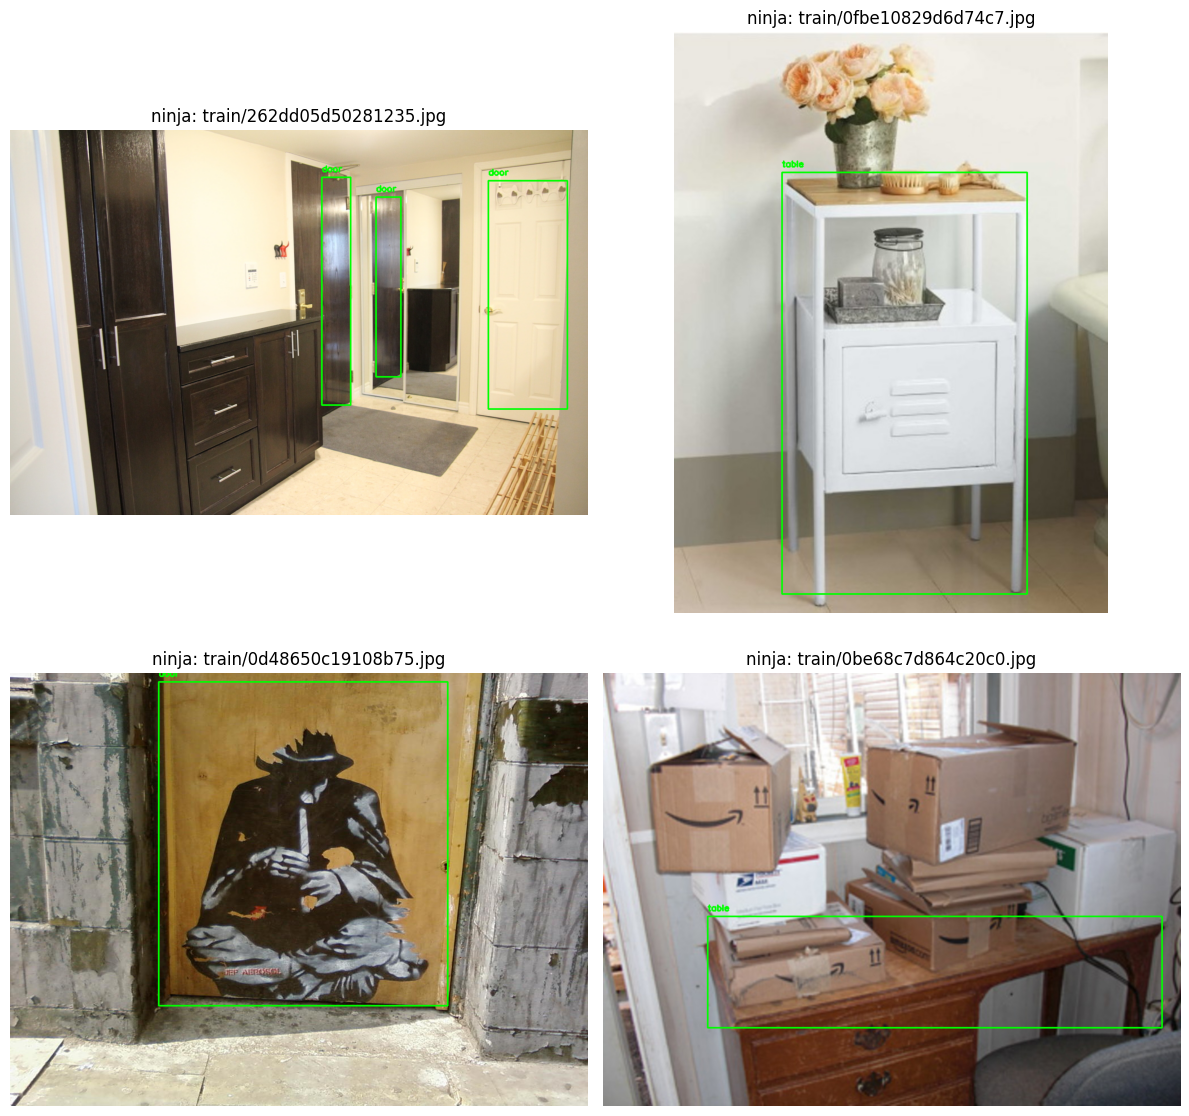

2025-03-21 15:57:42,704 - INFO - Displayed 4 images with bounding boxes from ninja


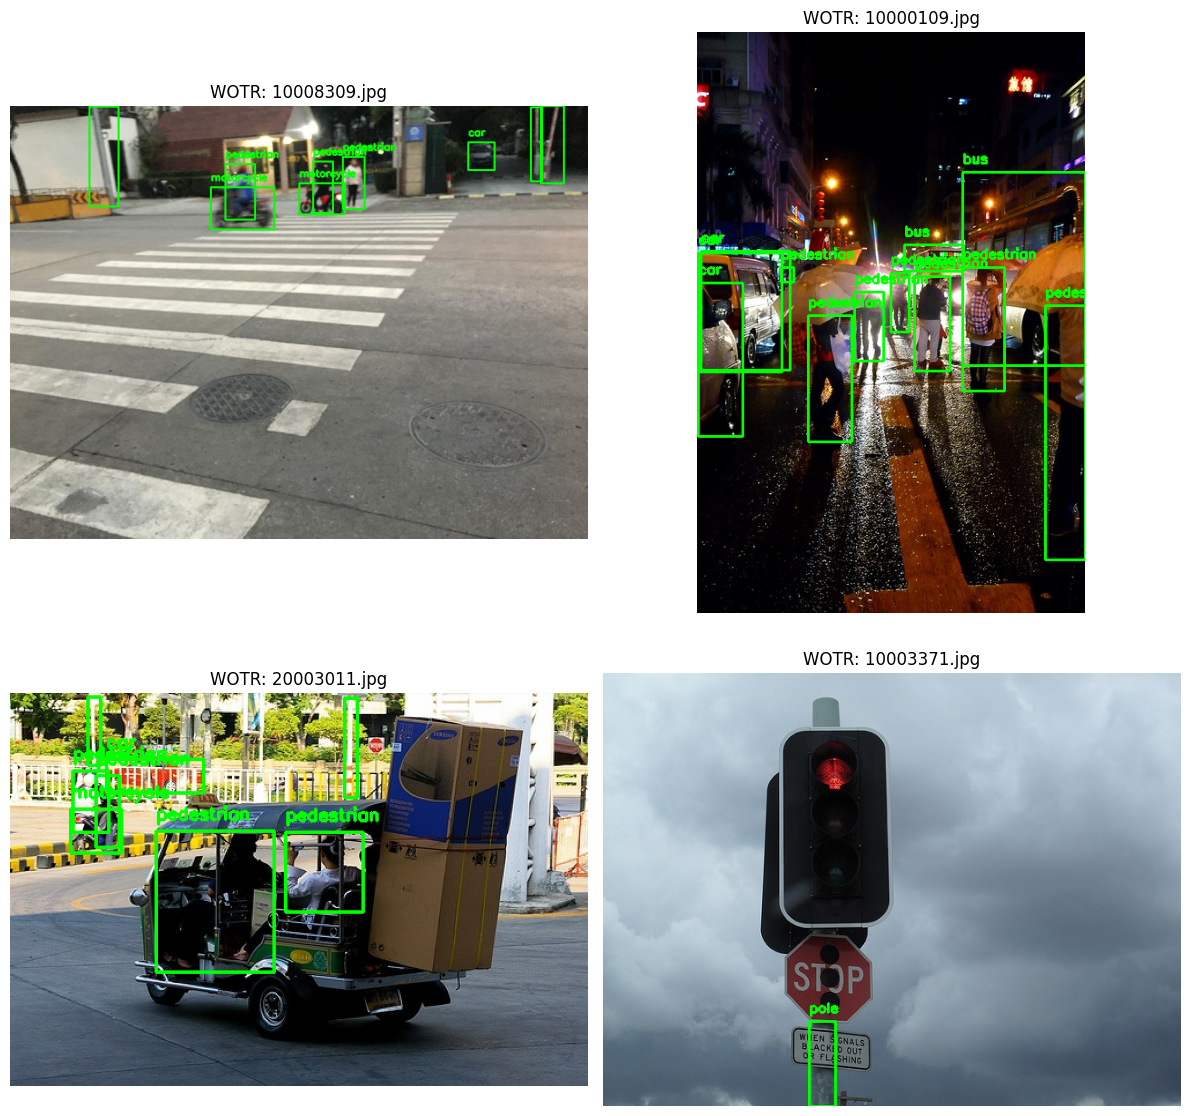

2025-03-21 15:57:43,350 - INFO - Displayed 4 images with bounding boxes from WOTR


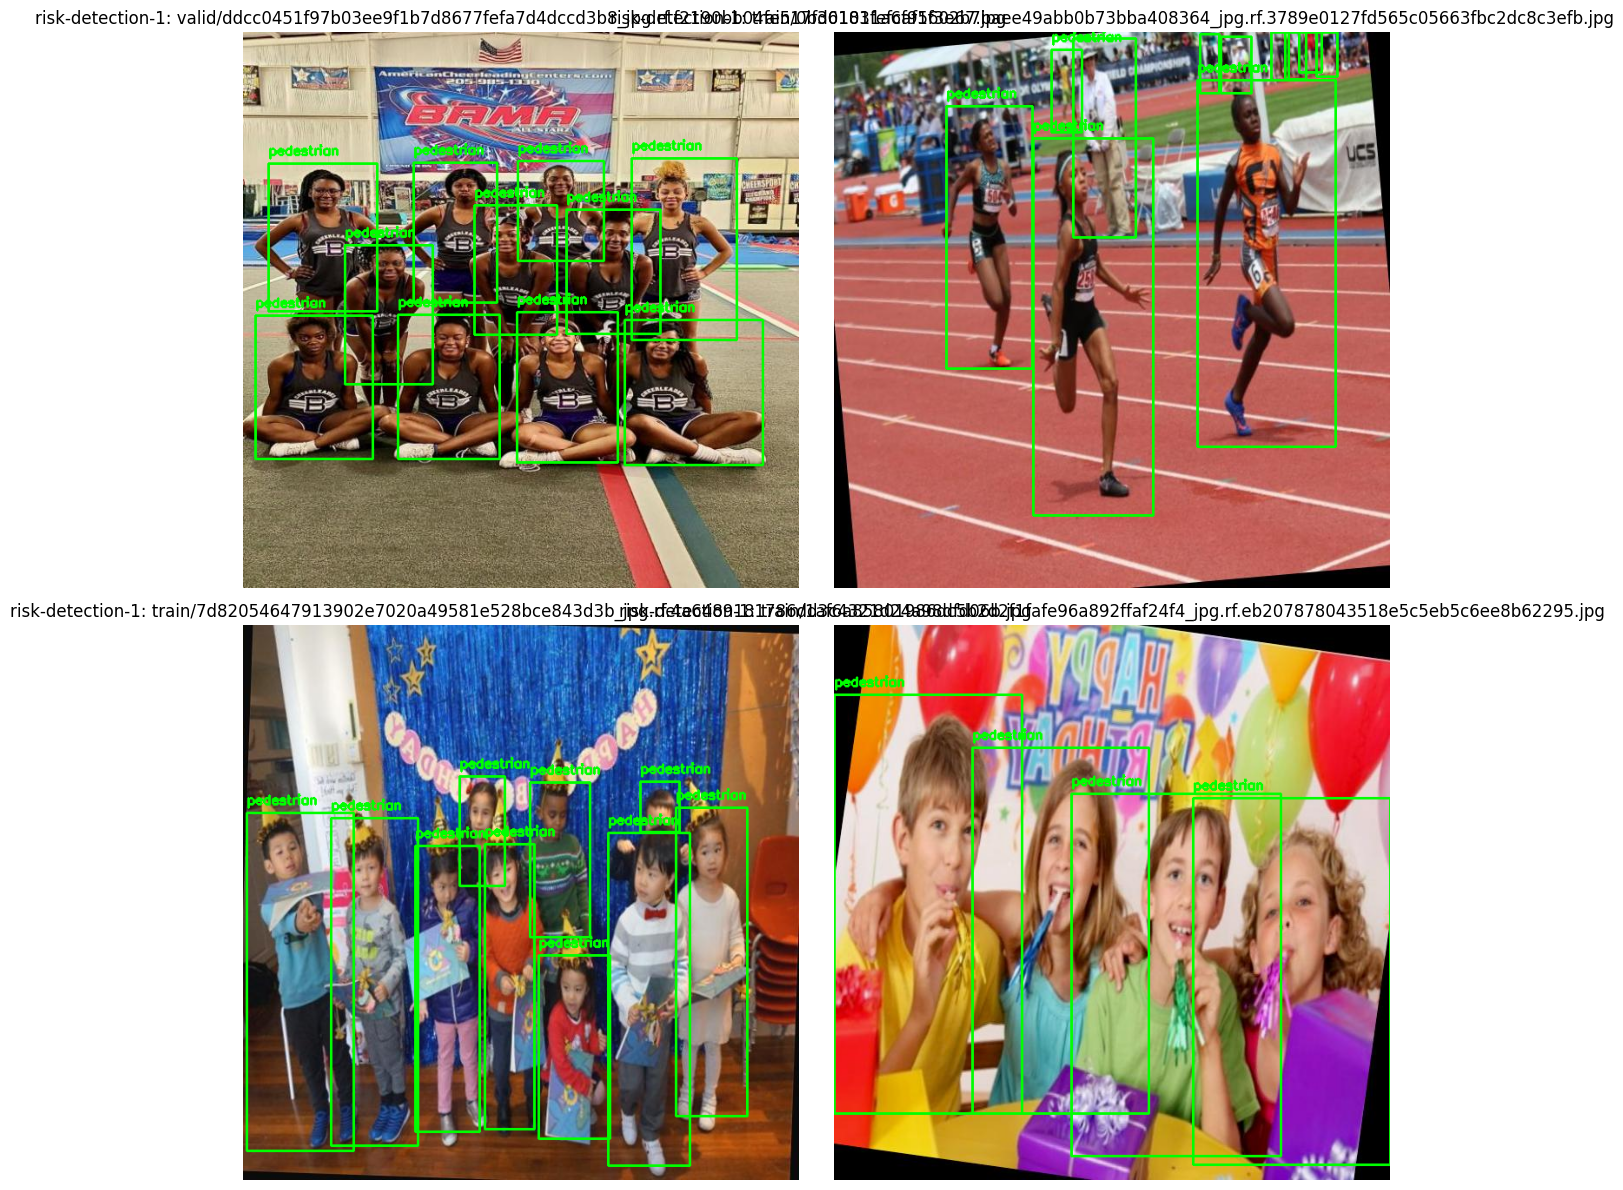

2025-03-21 15:57:44,244 - INFO - Displayed 4 images with bounding boxes from risk-detection-1


In [19]:
# Visualize 4 images from each dataset in a 2x2 grid
logger.info("\nStarting visualization generation...")
plot_images_with_bboxes(ninja_image_bbox_map, 'ninja')
plot_images_with_bboxes(wotr_image_bbox_map, 'WOTR')
plot_images_with_bboxes(risk_image_bbox_map, 'risk-detection-1')